
===== AAPL =====
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000039 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 101
[LightGBM] [Info] Number of data points in the train set: 1205, number of used features: 3
[LightGBM] [Info] Start training from score 0.237017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

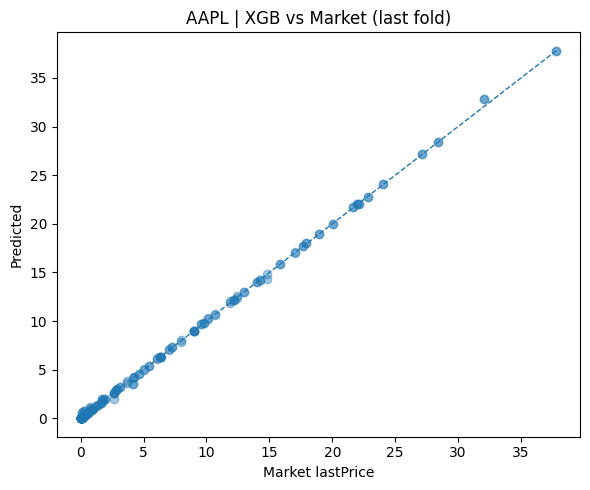

  ticker        mae_bs  gbr_mae_mean  \
0   AAPL  3.583342e-07      0.025434   

                                     gbr_mae_ci  xgb_mae_mean  \
0  (0.009977782593846818, 0.044645366787376545)      0.070554   

                                   xgb_mae_ci  \
0  (0.05538869072720411, 0.08847455118761044)   

                                     best_xgb_params       ols_mae  \
0  {'subsample': 0.8, 'n_estimators': 600, 'max_d...  3.979089e-07   

                                            features  
0  [bs_price, sigma_hat, iv_market, moneyness, mo...  


In [4]:
# ============================================================
# 0. Environment & Imports
# ============================================================
import os, warnings, datetime, pickle
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import yfinance as yf

from scipy.stats import norm
from scipy.optimize import brentq
from joblib import dump

# ML / evaluation
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import statsmodels.api as sm
import matplotlib.pyplot as plt


# ============================================================
# 1. Black‑Scholes core + implied‑vol inversion
# ============================================================

def bs_price(S, K, T, r, sigma, opt_type="call"):
    """Black‑Scholes price (no dividends)."""
    if sigma <= 0 or T <= 0:
        return np.nan
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if opt_type == "call":
        return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    else:
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)


def invert_iv(price, S, K, T, r, opt_type="call", sigma_bounds=(1e-4, 4.0)):
    """Numerically invert the BS formula to recover implied volatility."""
    if price <= 0 or T <= 0:
        return np.nan
    try:
        return brentq(lambda s: bs_price(S, K, T, r, s, opt_type) - price,
                      *sigma_bounds, maxiter=100, xtol=1e-6)
    except ValueError:
        return np.nan


def time_to_maturity(exp_str, today):
    return max((datetime.datetime.strptime(exp_str, "%Y-%m-%d") - today).days / 365, 1 / 365)


# ============================================================
# 2. Data collection
# ============================================================

def collect_option_data(symbol: str = "AAPL",
                        lookback_days: int = 30,
                        expirations_each_day: int = 6,
                        risk_free_rate: float = 0.045,
                        save_path: str | None = None):
    """Incrementally collect option chains & enrich with implied vol + BS benchmark."""
    if save_path is None:
        save_path = f"{symbol}_raw.parquet"
    if os.path.exists(save_path):
        df_all = pd.read_parquet(save_path)
        last_date = pd.to_datetime(df_all["date"]).max().date()
    else:
        df_all = pd.DataFrame()
        last_date = None

    today = datetime.datetime.utcnow().date()
    start = today - datetime.timedelta(days=lookback_days)

    for d in pd.date_range(start=start, end=today, freq="D"):
        if last_date is not None and d.date() <= last_date:
            continue  # already harvested
        try:
            tk = yf.Ticker(symbol)
            expiries = tk.options[:expirations_each_day]
            spot = tk.history(period="1d")["Close"].iloc[-1]

            for exp in expiries:
                chain = tk.option_chain(exp).calls  # only calls for simplicity
                if chain.empty:
                    continue

                chain = chain[(chain["bid"] > 0) | (chain["ask"] > 0)].copy()

                # timestamps / meta
                chain["date"] = d.date()
                chain["expiration"] = exp
                chain["S"] = spot
                chain["T"] = time_to_maturity(exp, d)
                chain["r"] = risk_free_rate

                # market last trade price (target)
                chain["lastPrice"] = chain["lastPrice"].replace(0, np.nan)
                chain = chain.dropna(subset=["lastPrice"])
                if chain.empty:
                    continue

                # implied vol and BS price at that IV (baseline)
                chain["iv_market"] = chain.apply(lambda row: invert_iv(row["lastPrice"],
                                                                         row["S"], row["strike"],
                                                                         row["T"], row["r"],
                                                                         opt_type="call"), axis=1)
                chain["bs_price"] = chain.apply(lambda row: bs_price(row["S"], row["strike"],
                                                                       row["T"], row["r"],
                                                                       row["iv_market"], "call"), axis=1)

                df_all = pd.concat([df_all, chain], ignore_index=True)
            print(f"✓ {d.date()} collected {symbol}")
        except Exception as e:
            print(f"× {d.date()} {symbol} failed: {e}")
            continue

    df_all.to_parquet(save_path, index=False)
    return df_all


# ============================================================
# 3. Feature engineering
# ============================================================

def add_iv_smoother(df: pd.DataFrame):
    """Stage‑1 LightGBM to smooth noisy implied vol surface (sigma_hat)."""
    iv_df = df.dropna(subset=["iv_market"]).copy()
    iv_df["moneyness"] = iv_df["strike"] / iv_df["S"]
    feat = ["strike", "S", "T", "moneyness"]
    Xv, yv = iv_df[feat], iv_df["iv_market"]
    lgb = LGBMRegressor(max_depth=3, n_estimators=400, learning_rate=0.05, random_state=2024)
    lgb.fit(Xv, yv)

    df["moneyness"] = df["strike"] / df["S"]
    df["sigma_hat"] = lgb.predict(df[feat])
    return df, lgb


def prepare_features(df: pd.DataFrame):
    """Final modelling frame & target."""

    # Drop rows with no lastPrice or bs_price
    df = df.dropna(subset=["lastPrice", "bs_price"]).copy()

    # ✅ Compute moneyness EARLY
    df["moneyness"] = df["strike"] / df["S"]

    # Liquidity & moneyness filters
    df = df[(df["openInterest"] > 10) & (df["volume"] > 0)]
    df = df[(df["moneyness"].between(0.8, 1.2))]

    # Smooth IV surface
    df, iv_smoother = add_iv_smoother(df)

    # Additional features
    df["moneyness_sq"] = df["moneyness"] ** 2
    df["log_moneyness"] = np.log(df["moneyness"])
    df["T_sq"] = df["T"] ** 2
    df["spread"] = df["ask"] - df["bid"]
    df["spread_pct"] = df["spread"] / df["lastPrice"]
    df["oi_log"] = np.log(df["openInterest"] + 1)
    df["vol_log"] = np.log(df["volume"] + 1)

    features = [
        "bs_price", "sigma_hat", "iv_market", "moneyness", "moneyness_sq",
        "log_moneyness", "T", "T_sq", "spread_pct", "oi_log", "vol_log"
    ]

    X = df[features]
    y = df["lastPrice"]

    # ✅ FINAL CLEANUP: drop rows where X or y still has NaN
    mask = X.notnull().all(axis=1) & y.notnull()
    X = X[mask]
    y = y[mask]

    return X, y, features, iv_smoother




# ============================================================
# 4. Cross‑validation helpers
# ============================================================

def rolling_cv(estimator, X, y, splits: int = 5, gap: int = 3):
    """Time‑series rolling CV with a gap to avoid leakage."""
    tscv = TimeSeriesSplit(n_splits=splits, gap=gap)
    mae, r2 = [], []
    for tr_idx, te_idx in tscv.split(X):
        estimator.fit(X.iloc[tr_idx], y.iloc[tr_idx])
        pred = estimator.predict(X.iloc[te_idx])
        mae.append(mean_absolute_error(y.iloc[te_idx], pred))
        r2.append(r2_score(y.iloc[te_idx], pred))
    return np.array(mae), np.array(r2)


def bootstrap_ci(scores, iterations: int = 1000, ci: int = 95):
    sample_means = [np.mean(np.random.choice(scores, len(scores), replace=True)) for _ in range(iterations)]
    low = np.percentile(sample_means, (100 - ci) / 2)
    high = np.percentile(sample_means, 100 - (100 - ci) / 2)
    return low, high


# ============================================================
# 5. Main pipeline (single or multiple tickers)
# ============================================================

def run_pipeline(tickers=("AAPL",), lookback: int = 30, expiries_per_day: int = 6):
    results = []
    for tk in tickers:
        print(f"\n===== {tk} =====")
        raw = collect_option_data(symbol=tk,
                                  lookback_days=lookback,
                                  expirations_each_day=expiries_per_day,
                                  save_path=f"{tk}_raw.parquet")

        X, y, feats, iv_model = prepare_features(raw)

        # baseline MAE (BS price at market IV)
        mae_bs = mean_absolute_error(y, X["bs_price"])

        # Model 1: Gradient Boosting
        gbr = GradientBoostingRegressor(random_state=2024)
        mae_gbr, _ = rolling_cv(gbr, X, y, splits=5, gap=3)

        # Model 2: XGBoost (random search)
        param_dist = {
            "n_estimators": [600, 900],
            "max_depth": [3, 4, 5],
            "learning_rate": [0.03, 0.05, 0.1],
            "subsample": [0.8],
            "colsample_bytree": [0.6, 0.8],
            "gamma": [0, 0.1]
        }
        xgb = XGBRegressor(objective="reg:squarederror", random_state=2024, n_jobs=-1)
        rs = RandomizedSearchCV(xgb, param_dist, n_iter=12, cv=3,
                                scoring="neg_mean_absolute_error", n_jobs=-1, verbose=0)
        rs.fit(X, y)
        best_xgb = rs.best_estimator_
        mae_xgb, r2_xgb = rolling_cv(best_xgb, X, y, splits=5, gap=3)

        # OLS sanity check (significant factors?)
        X_const = sm.add_constant(X[["bs_price", "moneyness", "spread_pct"]])
        ols = sm.OLS(y, X_const).fit()

        res = {
            "ticker": tk,
            "mae_bs": mae_bs,
            "gbr_mae_mean": mae_gbr.mean(),
            "gbr_mae_ci": bootstrap_ci(mae_gbr),
            "xgb_mae_mean": mae_xgb.mean(),
            "xgb_mae_ci": bootstrap_ci(mae_xgb),
            "best_xgb_params": rs.best_params_,
            "ols_mae": mean_absolute_error(y, ols.fittedvalues),
            "features": feats
        }
        results.append(res)

        # quick scatter – last fold
        plt.figure(figsize=(6, 5))
        test_idx = list(TimeSeriesSplit(n_splits=5, gap=3).split(X))[-1][1]
        plt.scatter(y.iloc[test_idx], best_xgb.predict(X.iloc[test_idx]), alpha=0.4)
        lim = max(y.iloc[test_idx].max(), best_xgb.predict(X.iloc[test_idx]).max())
        plt.plot([0, lim], [0, lim], "--", lw=1)
        plt.xlabel("Market lastPrice")
        plt.ylabel("Predicted")
        plt.title(f"{tk} | XGB vs Market (last fold)")
        plt.tight_layout()
        plt.show()

        # persist artefacts
        dump(best_xgb, f"{tk}_best_xgb.pkl")
        dump(iv_model, f"{tk}_iv_smoother.pkl")

    return pd.DataFrame(results)


# ============================================================
# 6. Script entry point
# ============================================================
if __name__ == "__main__":
    # Single ticker
    summary = run_pipeline(("AAPL",), lookback=45, expiries_per_day=6)
    print(summary)

    # Multiple tickers example
    # faang = ("AAPL", "MSFT", "AMZN", "GOOGL", "META")
    # print(run_pipeline(faang, lookback=30, expiries_per_day=6))
